In [1]:
#!pip install tensorflow
#!pip install ann-visualizer
#!pip install graphviz
#!pip install altair
#!pip install altair_viewer

In [120]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Data Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Data Pre-Processing Packages
from sklearn.preprocessing import StandardScaler
import random
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
import altair as alt
from sklearn.model_selection import train_test_split , GridSearchCV

# Individual Learning Packages
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 

# Ensemble Learning Packages
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, RandomForestRegressor, VotingClassifier

# Evaluation Metrics Packages
from sklearn.metrics import accuracy_score , classification_report, confusion_matrix , roc_curve , roc_auc_score

# Neural Network Packages

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model
import json
from ann_visualizer.visualize import ann_viz

In [121]:
url = 'https://raw.githubusercontent.com/jmrieck17/CSC_7810_Final_Project/main/diabetes.csv'
df = pd.read_csv(url)

print(df.head(5))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [122]:
print('Dataframe Shape:' , df.shape)
print()
print('Column Variables:')
print(list(df.columns))
print()
print('Unique Variables by Column:')
print(df.nunique())

Dataframe Shape: (768, 9)

Column Variables:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Unique Variables by Column:
Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


In [123]:
print('Rows with Null Values by Column:')
df.isnull().sum()

Rows with Null Values by Column:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [124]:
X = df.drop('Outcome', axis = 1)
y = df.Outcome

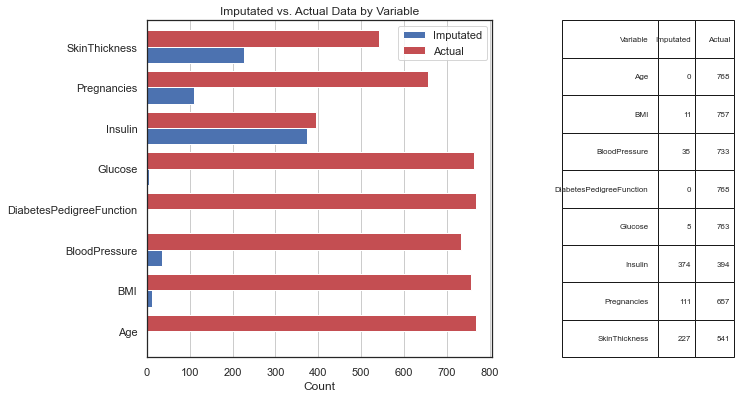

In [125]:
count_zero_cols = (X.eq(0)).sum()
count_nonzero_cols = (X.ne(0)).sum()

# combine both counts into one DataFrame
combined_counts = pd.concat([count_zero_cols, count_nonzero_cols], axis=1)
combined_counts.columns = ['Imputated', 'Actual']

# sort the column names alphabetically
combined_counts = combined_counts.sort_index()

# define color palette
colors = ['#4C72B0', '#C44E52']

# plot the results in a horizontal bar chart with sorted index
fig, ax = plt.subplots(figsize=(8, 6))
combined_counts.sort_index().plot(kind='barh', ax=ax, color=colors, width=0.8)

# add a grid
ax.grid(axis='x')

# add space for the axis labels
plt.subplots_adjust(left=0.3, bottom=0.1)

# add title and axis labels
ax.set_title("Imputated vs. Actual Data by Variable")
ax.set_xlabel("Count")

# create a table of counts
table_data = combined_counts.reset_index().values.tolist()
table_data.insert(0, ['Variable', 'Imputated', 'Actual'])
table = ax.table(cellText=table_data, loc='right', bbox=[1.2, 0, 0.5, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

# adjust bbox and font size to fit variable names
table.auto_set_column_width(col=list(range(combined_counts.shape[1])))
table.scale(3, 3)
table.auto_set_font_size(False)
table.set_fontsize(8)

plt.show()

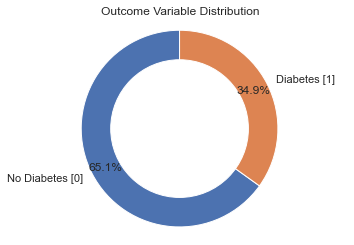

In [126]:
counts = df.groupby('Outcome').size()

fig, ax = plt.subplots()
ax.pie(counts, labels=['No Diabetes [0]', 'Diabetes [1]'], autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
plt.title('Outcome Variable Distribution')
plt.show()

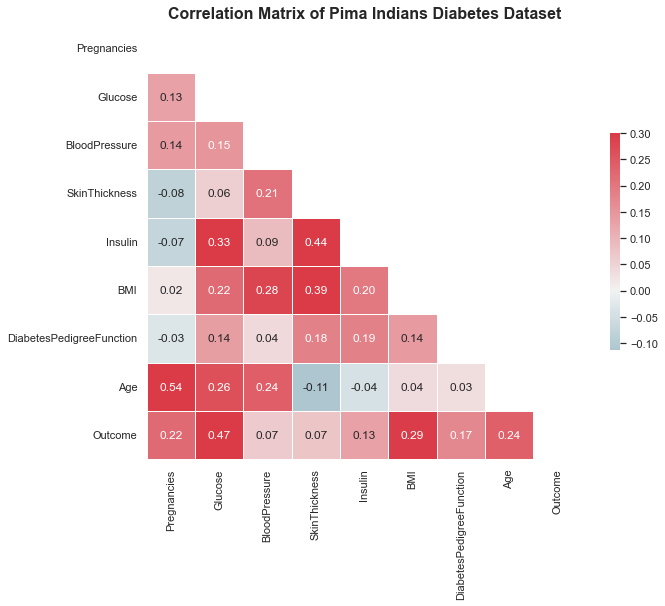

In [127]:
corr_matrix = df.corr()

# Set up the plot
sns.set(style="white")
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

# Rotate the x-axis labels
plt.xticks(rotation=90)

plt.title("Correlation Matrix of Pima Indians Diabetes Dataset", fontweight="bold", fontsize=16)

plt.show()

In [128]:
# This wrapper allows for me to choose which imputation method I want to use to fill in missing data

def impute_missing_values(df, method='KNN', n_neighbors=5):
    
    imputer = None

    if method == 'KNN':
        X = df.values.copy()
        X[X == 0] = np.nan
        imputer = KNNImputer(n_neighbors=n_neighbors)
        X_imputed = imputer.fit_transform(X)
        X_imputed = np.round(X_imputed, decimals=1)
        df_imputed = pd.DataFrame(X_imputed, columns=df.columns)
    
    elif method == 'Random Forest':
        X = df.values.copy()
        X[X == 0] = np.nan
        estimator = RandomForestRegressor(random_state=0)
        imputer = IterativeImputer(random_state=0, estimator=estimator)
        X_imputed = imputer.fit_transform(X)
        X_imputed = np.round(X_imputed, decimals=1)
        df_imputed = pd.DataFrame(X_imputed, columns=df.columns)
    
    elif method == 'Linear Regression':
        X = df.values.copy()
        X[X == 0] = np.nan
        imputer = KNNImputer(n_neighbors=n_neighbors)
        X_imputed = imputer.fit_transform(X)
        X_imputed[X == 0] = np.nan
        model = LinearRegression()
        model.fit(X_imputed, df.values)
        X_pred = model.predict(X_imputed)
        X_pred = np.round(X_pred, 1)
        X_pred[X == 0] = 0
        df_imputed = pd.DataFrame(X_pred, columns=df.columns)
    
    else:
        raise ValueError("Invalid imputation method. Must be one of ['KNN', 'Random Forest', 'Linear Regression']")

    return df_imputed

In [129]:
imputed_X = impute_missing_values(X, method='Linear Regression')
print(imputed_X)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            5.7    147.4           69.9           22.8     60.1  33.6   
1            0.8     83.8           63.0           21.2      7.2  26.1   
2            7.6    183.4           60.4           16.5     73.4  23.3   
3            0.6     87.8           61.9           16.9     53.4  27.4   
4            4.6    136.4           40.6           40.1    180.6  43.1   
..           ...      ...            ...            ...      ...   ...   
763         10.1    100.1           73.7           28.3     34.2  32.8   
764          1.3    120.9           66.4           20.6    105.6  36.3   
765          4.6    120.5           67.8           13.4     38.5  25.6   
766          1.1    124.6           58.2           23.9     38.3  30.3   
767          0.5     91.8           66.2           24.4     23.3  29.9   

     DiabetesPedigreeFunction   Age  
0                         0.6  50.0  
1                         0.4  31.0

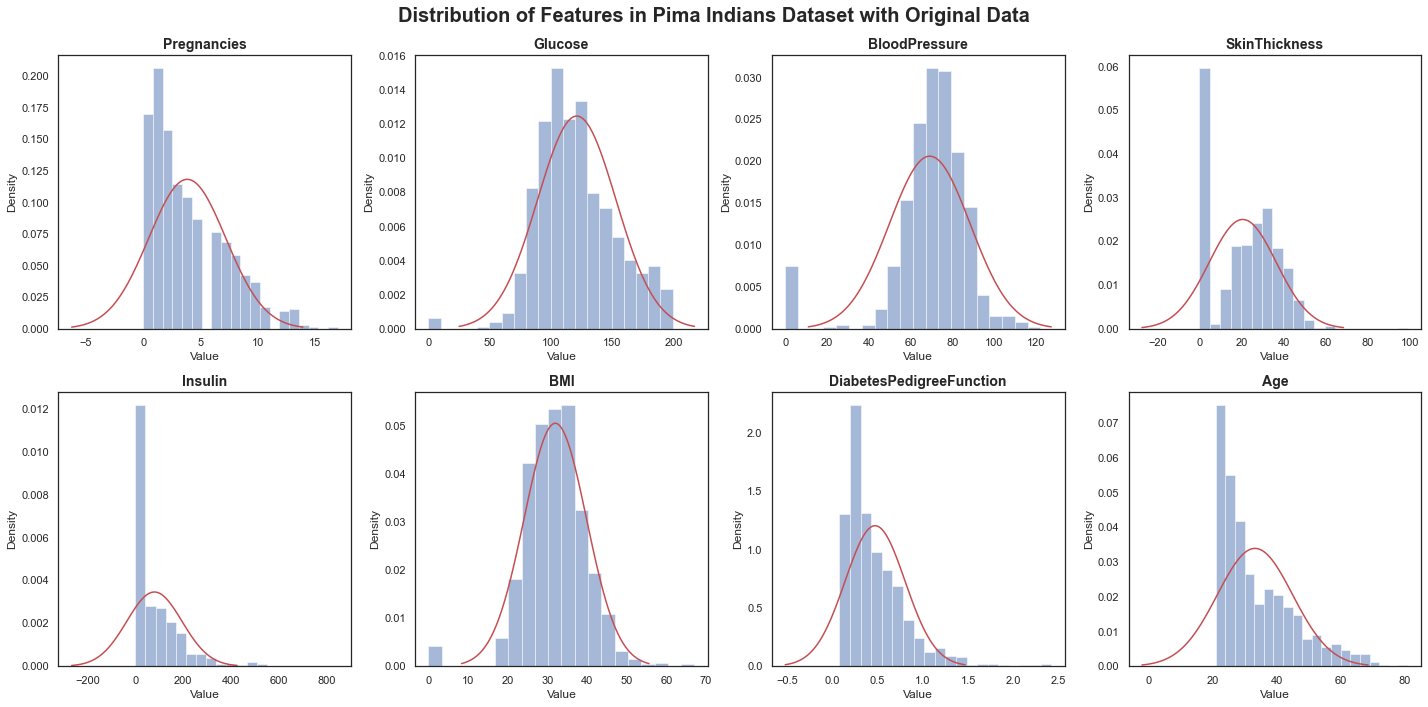

In [131]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axs = axs.flatten()

for i, col in enumerate(imputed_X.columns):
    data = imputed_X[col]
    mean, std = data.mean(), data.std()
    xmin, xmax = mean - 3 * std, mean + 3 * std
    x = np.linspace(xmin, xmax, 100)
    axs[i].hist(data, density=True, bins=20, alpha=0.5)
    axs[i].plot(x, stats.norm.pdf(x, mean, std), 'r')
    axs[i].set_title(col, fontsize=14, fontweight='bold')
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Density', fontsize=12)

plt.suptitle('Distribution of Features in Pima Indians Dataset with Linear Regression', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [100]:
# this wrapper allows me to choose whether I want to scale my data
# If using imputation method, use X_imputed, otherwise use X

def scale_data(X, scaling):
    if scaling:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = np.round(X_scaled, decimals=2)
        return pd.DataFrame(X_scaled, columns=X.columns)
    else:
        return X

In [101]:
X_scaled = scale_data(X, scaling = True)
print(X_scaled)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0           0.64     0.85           0.15           0.91    -0.69  0.20   
1          -0.84    -1.12          -0.16           0.53    -0.69 -0.68   
2           1.23     1.94          -0.26          -1.29    -0.69 -1.10   
3          -0.84    -1.00          -0.16           0.15     0.12 -0.49   
4          -1.14     0.50          -1.50           0.91     0.77  1.41   
..           ...      ...            ...            ...      ...   ...   
763         1.83    -0.62           0.36           1.72     0.87  0.12   
764        -0.55     0.03           0.05           0.41    -0.69  0.61   
765         0.34     0.00           0.15           0.15     0.28 -0.74   
766        -0.84     0.16          -0.47          -1.29    -0.69 -0.24   
767        -0.84    -0.87           0.05           0.66    -0.69 -0.20   

     DiabetesPedigreeFunction   Age  
0                        0.47  1.43  
1                       -0.37 -0.19

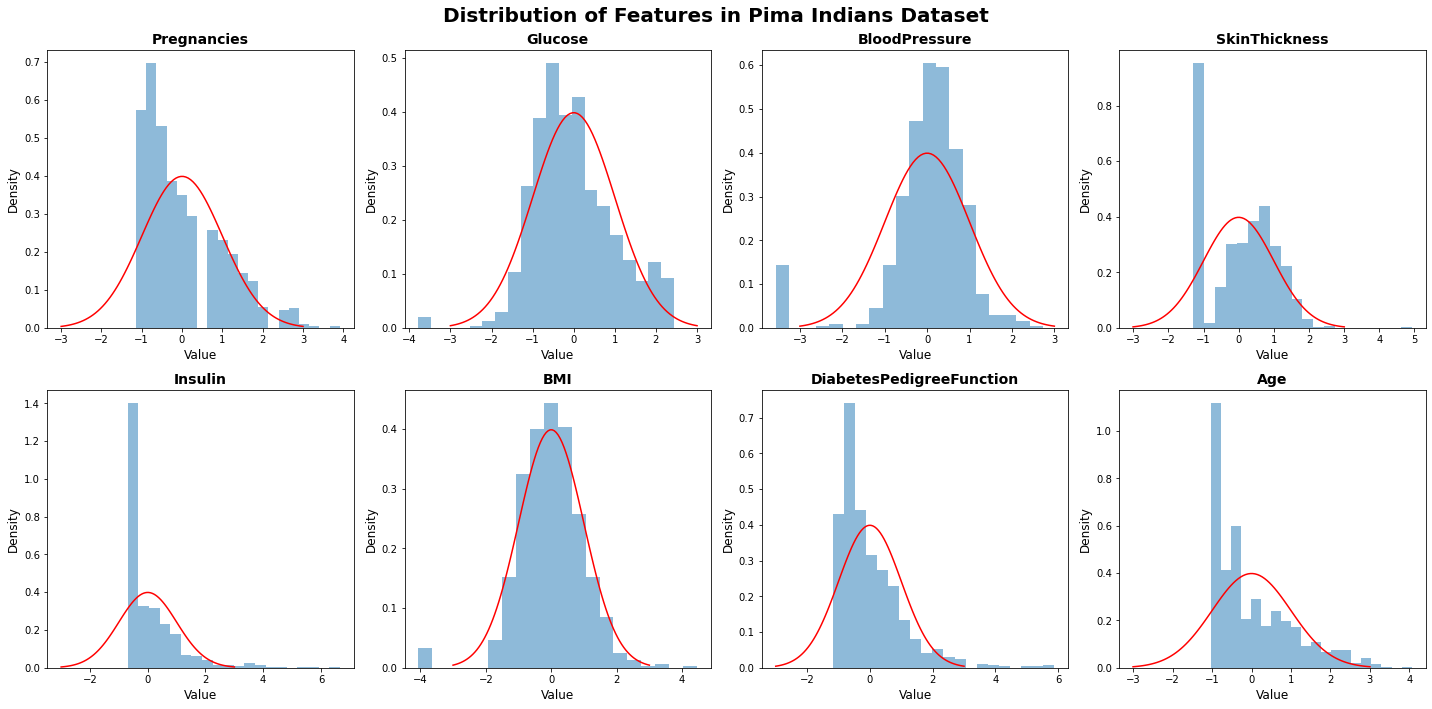

In [102]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axs = axs.flatten()

for i, col in enumerate(X_scaled.columns):
    data = X_scaled[col]
    mean, std = data.mean(), data.std()
    xmin, xmax = mean - 3 * std, mean + 3 * std
    x = np.linspace(xmin, xmax, 100)
    axs[i].hist(data, density=True, bins=20, alpha=0.5)
    axs[i].plot(x, stats.norm.pdf(x, mean, std), 'r')
    axs[i].set_title(col, fontsize=14, fontweight='bold')
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Density', fontsize=12)

plt.suptitle('Distribution of Features in Pima Indians Dataset', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [103]:
random.seed(1234)

In [104]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2 , random_state = 1234)

## Individual ML Methods

### Logistic Regression

In [260]:
parameters_lr = {
    'penalty' : ['none' , 'l1' , 'l2'],
    'C'       : [100 , 10 , 1.0 , 0.1 , 0.01],
    'solver'  : ['newton-cg' , 'lbfgs' , 'sag' , 'saga'],
    'max_iter' : [100]
}

cv = 5 # so this will split the dataset into 5 kfold validation chunks for the GridSearchCv to run through

lr = LogisticRegression()
clf = GridSearchCV(lr,                   
                   param_grid = parameters_lr,  
                   scoring = 'accuracy',        
                   cv = cv)  

clf.fit(X_train , y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy: {:.2%}".format(clf.best_score_))

Tuned Hyperparameters : {'C': 100, 'max_iter': 100, 'penalty': 'none', 'solver': 'newton-cg'}
Accuracy: 78.02%


In [261]:
lr = LogisticRegression(**clf.best_params_)
lr.fit(X_train , y_train)
predict_lr = lr.predict(X_test)

print("Accuracy: {:.2%}".format(accuracy_score(y_test, predict_lr)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predict_lr))
print('Classification Report Table:')
print(classification_report(y_test, predict_lr))

Accuracy: 77.27%
Confusion Matrix:
[[89 10]
 [25 30]]
Classification Report Table:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        99
           1       0.75      0.55      0.63        55

    accuracy                           0.77       154
   macro avg       0.77      0.72      0.73       154
weighted avg       0.77      0.77      0.76       154



roc_auc_score for Logistic regression: 84.79%


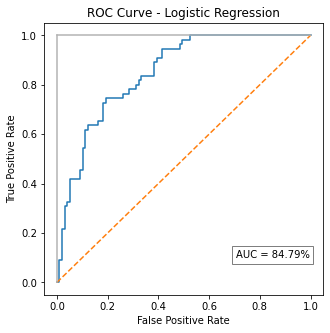

In [262]:
# ROC-AUC Graph

score_lr = lr.predict_proba(X_test)[:,1]

false_positive_ratelr, true_positive_ratelr, thresholdlr = roc_curve(y_test, score_lr)

roc_auc = roc_auc_score(y_test, score_lr)
print('roc_auc_score for Logistic regression: {:.2%}'.format(roc_auc))   
  
plt.subplots(1, figsize=(5,5))    
plt.title('ROC Curve - Logistic Regression')
plt.plot(false_positive_ratelr, true_positive_ratelr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

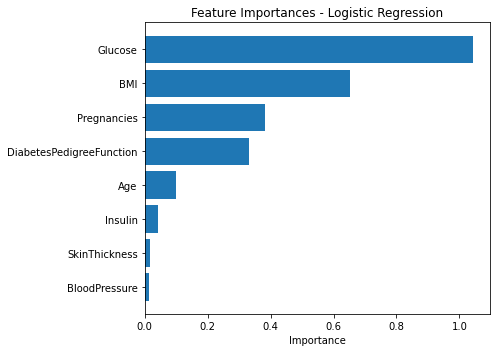

In [263]:
# Feature importance Graph

importances = np.abs(lr.coef_)[0]

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(7, 5))
plt.barh(range(X.shape[1]), importances[indices][::-1])
plt.yticks(range(X.shape[1]), X.columns[indices][::-1])
plt.title('Feature Importances - Logistic Regression')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Naive Bayes

In [264]:
random.seed(1234)

In [265]:
parameters_gnb = {
    'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]
}

cv = 5

gnb = GaussianNB()
nb = GridSearchCV(gnb,                   
                   param_grid = parameters_gnb,  
                   scoring = 'accuracy',        
                   cv = cv)  

nb.fit(X_train , y_train)

print("Tuned Hyperparameters :", nb.best_params_)
print("Accuracy: {:.2%}".format(nb.best_score_))

Tuned Hyperparameters : {'var_smoothing': 1e-09}
Accuracy: 74.59%


In [266]:
gnb = GaussianNB(**nb.best_params_)
gnb.fit(X_train , y_train)
predict_gnb = gnb.predict(X_test)

print("Accuracy: {:.2%}".format(accuracy_score(y_test, predict_gnb)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predict_gnb))
print('Classification Report Table:')
print(classification_report(y_test, predict_gnb))

Accuracy: 77.92%
Confusion Matrix:
[[86 13]
 [21 34]]
Classification Report Table:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        99
           1       0.72      0.62      0.67        55

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.78      0.77       154



roc_auc_score for Naive Bayes: 81.73%


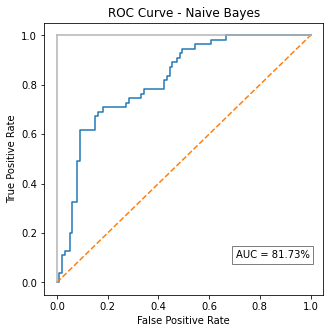

In [267]:
# ROC-AUC Graph

score_gnb = gnb.predict_proba(X_test)[:,1]

false_positive_rategnb, true_positive_rategnb, thresholdgnb = roc_curve(y_test, score_gnb)

roc_auc = roc_auc_score(y_test, score_gnb)
print('roc_auc_score for Naive Bayes: {:.2%}'.format(roc_auc))  
  
plt.subplots(1, figsize=(5,5))    
plt.title('ROC Curve - Naive Bayes')
plt.plot(false_positive_rategnb, true_positive_rategnb)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

### Decision Tree

In [268]:
random.seed(1234)

In [269]:
parameters_dtree = {
    'criterion' : [ 'gini', 'entropy', 'log_loss' ],
    'splitter'  : ['best', 'random']
}

cv = 5 # so this will split the dataset into 5 kfold validation chunks for the GridSearchCv to run through

dtree = DecisionTreeClassifier()
dtc = GridSearchCV(dtree,                   
                   param_grid = parameters_dtree,  
                   scoring = 'accuracy',        
                   cv = cv)  

dtc.fit(X_train , y_train)

print("Tuned Hyperparameters :", dtc.best_params_)
print("Accuracy: {:.2%}".format(dtc.best_score_))

Tuned Hyperparameters : {'criterion': 'gini', 'splitter': 'best'}
Accuracy: 71.82%


In [270]:
dtree = DecisionTreeClassifier(**dtc.best_params_)
dtree.fit(X_train , y_train)
predict_dtc = dtree.predict(X_test)

print("Accuracy: {:.2%}".format(accuracy_score(y_test, predict_dtc)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predict_dtc))
print('Classification Report Table:')
print(classification_report(y_test, predict_dtc))

Accuracy: 64.29%
Confusion Matrix:
[[74 25]
 [30 25]]
Classification Report Table:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        99
           1       0.50      0.45      0.48        55

    accuracy                           0.64       154
   macro avg       0.61      0.60      0.60       154
weighted avg       0.64      0.64      0.64       154



roc_auc_score for Decision Tree: 60.10%


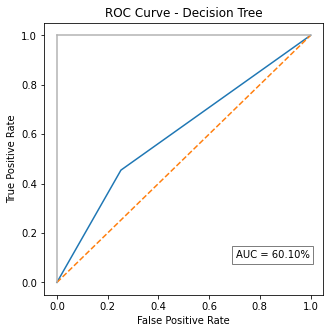

In [271]:
# ROC-AUC Graph

score_dtree = dtree.predict_proba(X_test)[:,1]

false_positive_ratedtree, true_positive_ratedtree, thresholddtree = roc_curve(y_test, score_dtree)

roc_auc = roc_auc_score(y_test, score_dtree)
print('roc_auc_score for Decision Tree: {:.2%}'.format(roc_auc))  
  
plt.subplots(1, figsize=(5,5))    
plt.title('ROC Curve - Decision Tree')
plt.plot(false_positive_ratedtree, true_positive_ratedtree)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

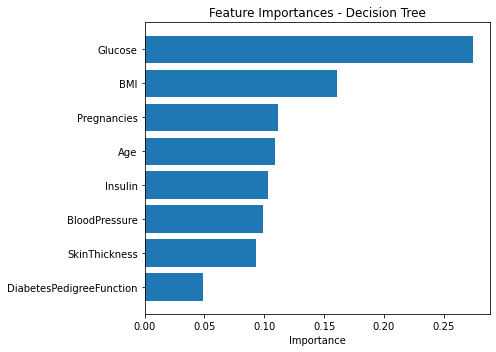

In [272]:
# Feature importance Graph

importances = dtree.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize=(7, 5))
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.title('Feature Importances - Decision Tree')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### K-Nearest Neighbor

In [273]:
random.seed(1234)

In [274]:
parameters_knn = {
    'n_neighbors' : [1,3,5,7,9,11,13,15,17,19,21,23,25,27],
    'weights'       : ['uniform' , 'distance'],
    'metric'  : ['euclidean' , 'manhattan' , 'minkowski']
}

cv = 5

knn = KNeighborsClassifier()
knneighbors = GridSearchCV(knn,                   
                   param_grid = parameters_knn,  
                   scoring = 'accuracy',        
                   cv = cv)  

knneighbors.fit(X_train , y_train)

print("Tuned Hyperparameters :", knneighbors.best_params_)
print("Accuracy: {:.2%}".format(knneighbors.best_score_))

Tuned Hyperparameters : {'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'distance'}
Accuracy: 77.69%


In [275]:
knn = KNeighborsClassifier(**knneighbors.best_params_)
knn.fit(X_train , y_train)
predict_knn = knn.predict(X_test)

print("Accuracy: {:.2%}".format(accuracy_score(y_test, predict_knn)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predict_knn))
print('Classification Report Table:')
print(classification_report(y_test, predict_knn))

Accuracy: 75.97%
Confusion Matrix:
[[86 13]
 [24 31]]
Classification Report Table:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        99
           1       0.70      0.56      0.63        55

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



roc_auc_score for K-Nearest Neighbor: 80.72%


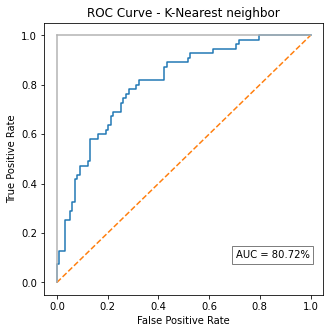

In [276]:
# ROC-AUC Graph

score_knn = knn.predict_proba(X_test)[:,1]

false_positive_rateknn, true_positive_rateknn, thresholdknn = roc_curve(y_test, score_knn)

roc_auc = roc_auc_score(y_test, score_knn)
print('roc_auc_score for K-Nearest Neighbor: {:.2%}'.format(roc_auc))  
  
plt.subplots(1, figsize=(5,5))    
plt.title('ROC Curve - K-Nearest neighbor')
plt.plot(false_positive_rateknn, true_positive_rateknn)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

## Ensemble Methods

### Random Forest Classifier

In [277]:
random.seed(1234)

In [278]:
parameters_rf = {
    'n_estimators' : [10,50,100,200,500],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'n_jobs' : [-1]
}

cv = 5

rf = RandomForestClassifier(random_state = 1234)
rforest = GridSearchCV(rf,                  
                   param_grid = parameters_rf,  
                   scoring = 'accuracy',        
                   cv = cv)  

rforest.fit(X_train , y_train)

print("Tuned Hyperparameters :", rforest.best_params_)
print("Accuracy: {:.2%}".format(rforest.best_score_))

Tuned Hyperparameters : {'criterion': 'entropy', 'n_estimators': 50, 'n_jobs': -1}
Accuracy: 77.69%


In [279]:
rf = RandomForestClassifier(**rforest.best_params_)
rf.fit(X_train , y_train)
predict_rf = rf.predict(X_test)

print("Accuracy: {:.2%}".format(accuracy_score(y_test, predict_rf)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predict_rf))
print('Classification Report Table:')
print(classification_report(y_test, predict_rf))

Accuracy: 75.32%
Confusion Matrix:
[[85 14]
 [24 31]]
Classification Report Table:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        99
           1       0.69      0.56      0.62        55

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



roc_auc_score for Random Forest: 83.76%


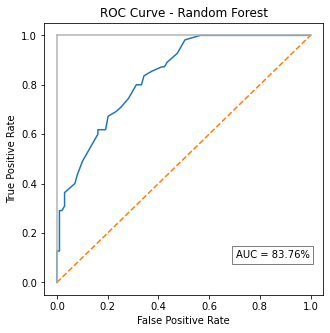

In [280]:
# ROC-AUC Graph

score_rf = rf.predict_proba(X_test)[:,1]

false_positive_raterf, true_positive_raterf, thresholdrf = roc_curve(y_test, score_rf)

roc_auc = roc_auc_score(y_test, score_rf)
print('roc_auc_score for Random Forest: {:.2%}'.format(roc_auc))  
  
plt.subplots(1, figsize=(5,5))    
plt.title('ROC Curve - Random Forest')
plt.plot(false_positive_raterf, true_positive_raterf)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

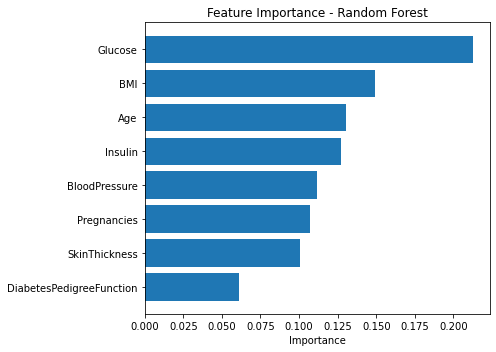

In [281]:
# Feature importance Graph

importances = rf.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize=(7, 5))
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### Majority Vote Classifier

In [282]:
random.seed(1234)

In [283]:
# I'm going to use the same hyper-parameters above in my models down below

lr = LogisticRegression(**clf.best_params_)
gnb = GaussianNB(**nb.best_params_)
knn = KNeighborsClassifier(**knneighbors.best_params_)

ensemble = VotingClassifier(estimators=[('lr', lr) , ('gnb', gnb) , ('knn', knn)], 
                            voting='soft')

ensemble.fit(X_train, y_train)
predict_ens_testing = ensemble.predict(X_test)

print("Test Set Accuracy: {:.2%}".format(accuracy_score(y_test, predict_ens_testing)))
print('Test Set Confusion Matrix:')
print(confusion_matrix(y_test, predict_ens_testing))
print('Test Set Classification Report Table:')
print(classification_report(y_test, predict_ens_testing))

Test Set Accuracy: 77.92%
Test Set Confusion Matrix:
[[89 10]
 [24 31]]
Test Set Classification Report Table:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.76      0.56      0.65        55

    accuracy                           0.78       154
   macro avg       0.77      0.73      0.74       154
weighted avg       0.78      0.78      0.77       154



roc_auc_score for Majority Vote: 83.78%


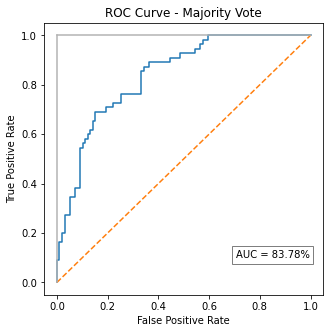

In [284]:
# ROC-AUC Graph

score_mv = ensemble.predict_proba(X_test)[:,1]

false_positive_ratemv, true_positive_ratemv, thresholdmv = roc_curve(y_test, score_mv)

roc_auc = roc_auc_score(y_test, score_mv)
print('roc_auc_score for Majority Vote: {:.2%}'.format(roc_auc))   
  
plt.subplots(1, figsize=(5,5))    
plt.title('ROC Curve - Majority Vote')
plt.plot(false_positive_ratemv, true_positive_ratemv)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

### Gradient Boosting Classifier

In [285]:
random.seed(1234)

In [286]:
parameters_gb = {
    'n_estimators' : [10,50,100,200,500],
    'learning_rate' :[0.001 , 0.01 , 0.1 , 1],
    'loss' : ['log_loss', 'deviance', 'exponential']
}

cv = 5

gbc = GradientBoostingClassifier()
gradboost = GridSearchCV(gbc,                  
                   param_grid = parameters_gb,  
                   scoring = 'accuracy',        
                   cv = cv)  

gradboost.fit(X_train , y_train)

print("Tuned Hyperparameters :", gradboost.best_params_)
print("Accuracy: {:.2%}".format(gradboost.best_score_))

Tuned Hyperparameters : {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Accuracy: 76.87%


In [287]:
gbc = GradientBoostingClassifier(**gradboost.best_params_)
gbc.fit(X_train , y_train)
predict_gbc = gbc.predict(X_test)

print("Accuracy: {:.2%}".format(accuracy_score(y_test, predict_gbc)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predict_gbc))
print('Classification Report Table:')
print(classification_report(y_test, predict_gbc))

Accuracy: 75.32%
Confusion Matrix:
[[86 13]
 [25 30]]
Classification Report Table:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        99
           1       0.70      0.55      0.61        55

    accuracy                           0.75       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



roc_auc_score for Gradient Boosting: 83.71%


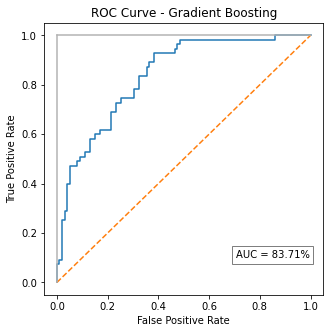

In [288]:
# ROC-AUC Graph

score_gbc = gbc.predict_proba(X_test)[:,1]

false_positive_rategbc, true_positive_rategbc, thresholdgbc = roc_curve(y_test, score_gbc)

roc_auc = roc_auc_score(y_test, score_gbc)
print('roc_auc_score for Gradient Boosting: {:.2%}'.format(roc_auc)) 
  
plt.subplots(1, figsize=(5,5))    
plt.title('ROC Curve - Gradient Boosting')
plt.plot(false_positive_rategbc, true_positive_rategbc)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

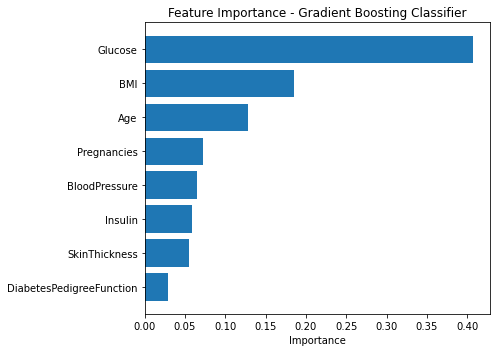

In [289]:
# Feature importance Graph

importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7, 5))
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.title('Feature Importance - Gradient Boosting Classifier')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Neural Network

In [105]:
random.seed(1234)

In [106]:
# Define the function to create a Keras model
def create_model(activation='relu', hidden_layers=1, neurons=32, optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation))
    for i in range(hidden_layers-1):
        model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create a KerasClassifier object for GridSearchCV
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150],
    'activation': ['relu', 'tanh' , 'sigmoid'],
    'hidden_layers': [1, 2, 3, 4],
    'neurons': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop']
}

# Create a GridSearchCV object to search for the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(X_train , y_train)

# Print the best hyperparameters and the best accuracy score
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy Score: {:.2%}".format(grid_result.best_score_))

Best Hyperparameters: {'activation': 'relu', 'batch_size': 16, 'epochs': 50, 'hidden_layers': 1, 'neurons': 64, 'optimizer': 'rmsprop'}
Best Accuracy Score: 79.97%


In [107]:
# Create a new Keras model with the best hyperparameters
best_params = grid_result.best_params_

model = create_model(
    activation=best_params['activation'],
    hidden_layers=best_params['hidden_layers'],
    neurons=best_params['neurons'],
    optimizer=best_params['optimizer']
)

# Train the model with the best hyperparameters
model.fit(X_train , y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: {:.4f}".format(score[0]))
print("Test Accuracy: {:.2%}".format(score[1]))

Test Loss: 0.4930
Test Accuracy: 72.73%


5/5 [==============================] - 0s 3ms/step


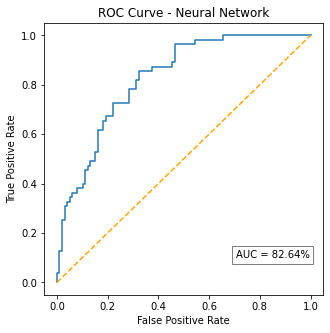

In [108]:
# ROC-AUC Graph

y_pred_proba = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.subplots(1, figsize=(5,5))
plt.title('ROC Curve - Neural Network')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.85, 0.1, 'AUC = {:.2%}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5), ha='center')
plt.show()

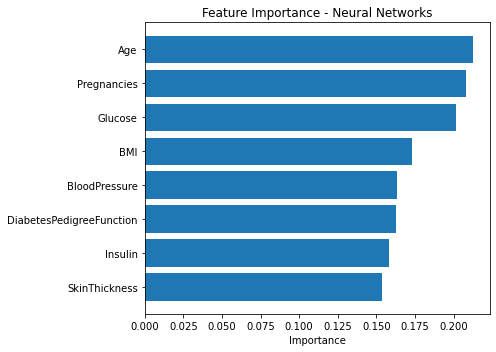

In [109]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Get the weights from the first layer of the model
weights = model.layers[0].get_weights()[0]

# Calculate the mean absolute weight for each input feature
feature_importance = np.mean(np.abs(weights), axis=1)

# Sort the feature importance values in ascending order
sorted_idx = np.argsort(feature_importance)

# Plot the feature importances
plt.figure(figsize=(7, 5))
plt.barh(range(X_train_df.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train_df.shape[1]), X_train_df.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance - Neural Networks')
plt.tight_layout()
plt.show()

In [110]:
topology = model.to_json()
print(json.dumps(json.loads(topology), indent=2))

{
  "class_name": "Sequential",
  "config": {
    "name": "sequential_13",
    "layers": [
      {
        "class_name": "InputLayer",
        "config": {
          "batch_input_shape": [
            null,
            8
          ],
          "dtype": "float32",
          "sparse": false,
          "ragged": false,
          "name": "dense_32_input"
        }
      },
      {
        "class_name": "Dense",
        "config": {
          "name": "dense_32",
          "trainable": true,
          "dtype": "float32",
          "batch_input_shape": [
            null,
            8
          ],
          "units": 64,
          "activation": "relu",
          "use_bias": true,
          "kernel_initializer": {
            "class_name": "GlorotUniform",
            "config": {
              "seed": null
            }
          },
          "bias_initializer": {
            "class_name": "Zeros",
            "config": {}
          },
          "kernel_regularizer": null,
          "bias_regula

In [111]:
def create_ann_viz_model(best_params, X):
    model = create_model(
        activation=best_params['activation'],
        hidden_layers=best_params['hidden_layers'],
        neurons=best_params['neurons'],
        optimizer=best_params['optimizer']
    )

    # Train the model with the best hyperparameters
    model.fit(X, y, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)

    # Create a new ann_viz model with the updated weights
    ann_viz_model = ann_viz(model, title="Neural Network Visualization")

    return ann_viz_model

ann_viz_model = create_ann_viz_model(best_params, X)